In [1]:
%env KERAS_BACKEND = tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# keras.functions
from keras.models import Sequential, Model
from keras.layers import Input
from keras.layers import Dense, Activation, Lambda, concatenate
from tensorflow.keras.optimizers import SGD  #notice! use tensorflow.keras.optimizers

# keras.dataset
from keras.datasets import mnist  # 手寫辨識資料  mnist

# keras.utilis function
from keras.utils import np_utils    # one-Hot encoding 0 ~ 9 改成向量的 utils

from keras import backend as K

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
x_train = x_train.reshape(60000, 784)  # 矩陣拉平
x_test = x_test.reshape(10000, 784)

x_train = x_train/255
x_test = x_test/255

In [6]:
enc_1 = Dense(100, activation = 'sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation = 'sigmoid')
dec_1 = Dense(784, activation = 'sigmoid')

In [7]:
x = Input(shape = (784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [8]:
def sampling(args):  # 抽樣函數
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape = (2, ), mean = 0., stddev = 1)
    
    return z_mean + K.exp(z_log_var/2)* epsilon

In [9]:
z = Lambda(sampling, output_shape = (2, ))([z_mean, z_log_var])

In [10]:
dec_x = dec_2(z)
x_reconstructed = dec_1(dec_x)

In [11]:
VAE = Model(x, x_reconstructed)
VAE.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0           []                               
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          78500       ['input_1[0][0]']                
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            202         ['dense[0][0]']                  
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            202         ['dense[0][0]']                  
______________________________________________________________________________________________

In [12]:
from keras import metrics

In [13]:
def vae_loss(x, x_recon):
    recovery_loss = 784*metrics.binary_crossentropy(x, x_recon)   # 圖的重建
    kl_loss = -0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = -1)  #像常態分配的函數
    
    return recovery_loss + kl_loss

In [14]:
VAE.compile(loss = vae_loss, optimizer = 'Nadam')

In [15]:
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
VAE.fit(x_train, x_train, batch_size = 32, epochs = 100)

Epoch 1/100


TypeError: in user code:

    /Users/cheng/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:850 train_function  *
        return step_function(self, iterator)
    /Users/cheng/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:839 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/cheng/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:832 run_step  **
        outputs = model.train_step(data)
    /Users/cheng/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:781 train_step
        loss = self.compiled_loss(
    /Users/cheng/opt/anaconda3/lib/python3.8/site-packages/keras/engine/compile_utils.py:239 __call__
        self._loss_metric.update_state(
    /Users/cheng/opt/anaconda3/lib/python3.8/site-packages/keras/utils/metrics_utils.py:73 decorated
        update_op = update_state_fn(*args, **kwargs)
    /Users/cheng/opt/anaconda3/lib/python3.8/site-packages/keras/metrics.py:177 update_state_fn
        return ag_update_state(*args, **kwargs)
    /Users/cheng/opt/anaconda3/lib/python3.8/site-packages/keras/metrics.py:449 update_state  **
        sample_weight = tf.__internal__.ops.broadcast_weights(
    /Users/cheng/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83 asarray
        return array(a, dtype, copy=False, order=order)
    /Users/cheng/opt/anaconda3/lib/python3.8/site-packages/keras/engine/keras_tensor.py:244 __array__
        raise TypeError(

    TypeError: Cannot convert a symbolic Keras input/output to a numpy array. This error may indicate that you're trying to pass a symbolic value to a NumPy call, which is not supported. Or, you may be trying to pass Keras symbolic inputs/outputs to a TF API that does not register dispatching, preventing Keras from automatically converting the API call to a lambda layer in the Functional Model.


### 視覺化VAE

In [17]:
VAE_Encoder = Model(x, z_mean)
VAE_Encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [21]:
h_input = Input(shape = (2,))
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))
VAE_Decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_4 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


In [22]:
idx = np.random.randint(x_train.shape[0])
print('第 %d 圖的 latent 表示%s' %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))

第 27721 圖的 latent 表示[[-0.6525204   0.58464086]]


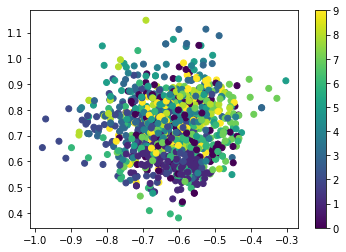

In [23]:
idices = np.random.randint(x_test.shape[0], size = 1000)
VAE_latents = VAE_Encoder.predict(x_test[idices])
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c = y_test[idices])
plt.colorbar()
plt.show()

In [24]:
def normalize_to_unit(x):
    x -= x.min()
    x /= x.max()
    return x

In [25]:
n = 15
digit_size = 28
vae_figure = np.zeros((digit_size*n, digit_size*n))
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)

In [26]:
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        vae_figure[(n-i-1)*digit_size:(n-i)*digit_size, 
                   j*digit_size:(j+1)*digit_size] = normalize_to_unit(digit)

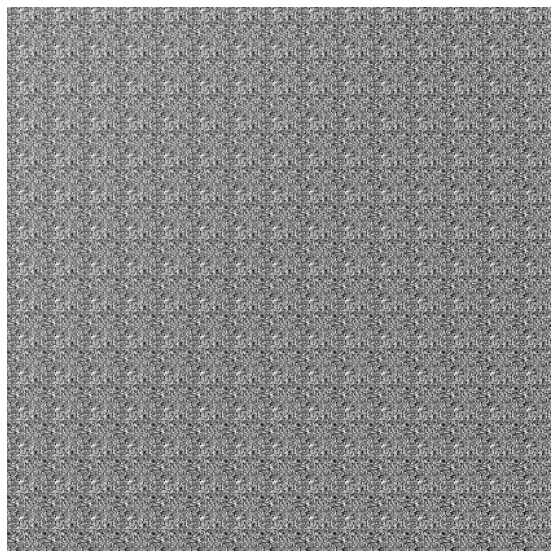

In [27]:
plt.figure(figsize = (10, 10))
plt.imshow(vae_figure, cmap = 'Greys_r')
plt.axis('off')
plt.show()

Autoencoder 與 Variational Autoencoder 作視覺化比較  
variational autoencoder 局部關係較明顯  
因此要做壓縮後的分群 可以選擇VAE